In [212]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [213]:
# Directory that holds the data
DATA_DIR = './data/Unified'


# Subdirectories for each class
glioma_train = os.path.join(DATA_DIR, 'glioma_tumor')
meningioma_train = os.path.join(DATA_DIR, 'meningioma_tumor')
no_tumor_train = os.path.join(DATA_DIR, 'no_tumor')
pituitary_train = os.path.join(DATA_DIR, 'pituitary_tumor')



# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(glioma_train))} images of glioma tumor in train directory.")
print(f"There are {len(os.listdir(meningioma_train))} images of meningioma tumor in train directory.")
print(f"There are {len(os.listdir(no_tumor_train))} images of no_tumor in train directory.")
print(f"There are {len(os.listdir(pituitary_train))} images of pituitary tumor in train directory.")

There are 926 images of glioma tumor in train directory.
There are 937 images of meningioma tumor in train directory.
There are 500 images of no_tumor in train directory.
There are 901 images of pituitary tumor in train directory.


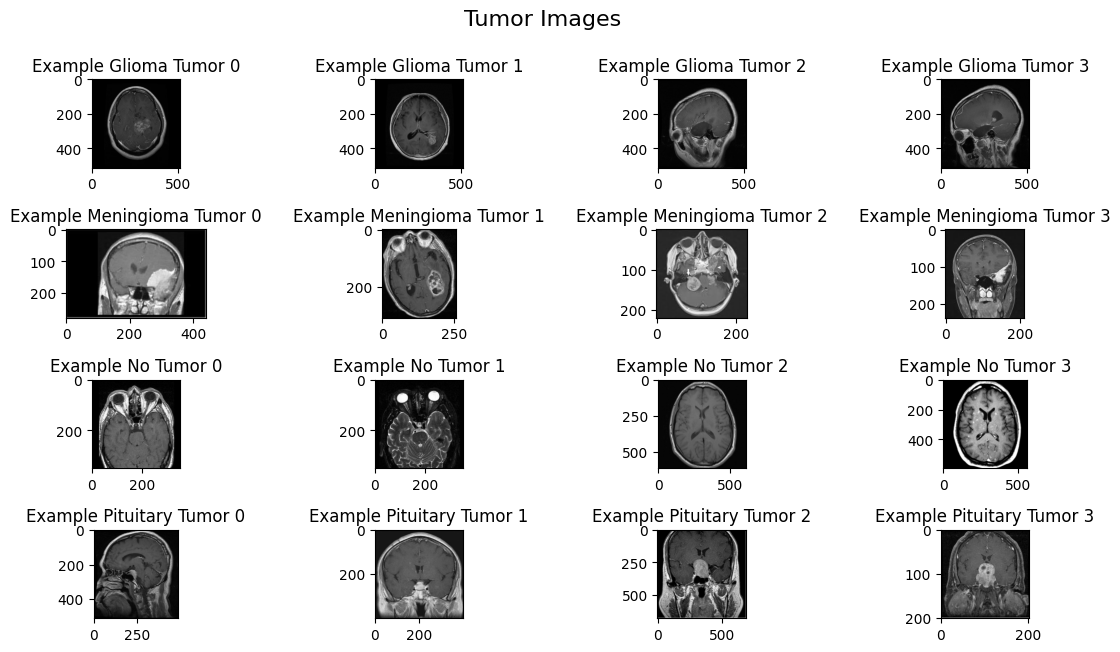

In [214]:
# Get the filenames for cats and dogs images
glioma_filenames = [os.path.join(glioma_train, filename) for filename in os.listdir(glioma_train)]
meningioma_filenames = [os.path.join(meningioma_train, filename) for filename in os.listdir(meningioma_train)]
no_tumor_filenames = [os.path.join(no_tumor_train, filename) for filename in os.listdir(no_tumor_train)]
pituitary_filenames = [os.path.join(pituitary_train, filename) for filename in os.listdir(pituitary_train)]


fig, axes = plt.subplots(4, 4, figsize=(14, 7))
fig.suptitle('Tumor Images', fontsize=16)

# Plot the first 4 images of each class
for i, glioma_image in enumerate(glioma_filenames[:4]):
    img = tf.keras.utils.load_img(glioma_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Glioma Tumor {i}')

for i, meningioma_image in enumerate(meningioma_filenames[:4]):
    img = tf.keras.utils.load_img(meningioma_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Meningioma Tumor {i}')

for i, no_tumor_image in enumerate(no_tumor_filenames[:4]):
    img = tf.keras.utils.load_img(no_tumor_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example No Tumor {i}')

for i, pituitary_image in enumerate(pituitary_filenames[:4]):
    img = tf.keras.utils.load_img(pituitary_image)
    axes[3, i].imshow(img)
    axes[3, i].set_title(f'Example Pituitary Tumor {i}')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.7)

plt.show()

## Train and Validation Datasets

In [215]:
training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    image_size=(150,150),
    batch_size=128,
    label_mode="categorical",
    validation_split=0.1,
    subset="both",
    seed=42 
)

Found 3264 files belonging to 4 classes.
Using 2938 files for training.
Using 326 files for validation.


In [217]:
# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

training_dataset_final = (training_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

In [218]:
# Class weights
num_classes = 4
n_glioma = len(os.listdir(glioma_train))
n_meningioma = len(os.listdir(meningioma_train))
n_no_tumor = len(os.listdir(no_tumor_train))
n_pituitary = len(os.listdir(pituitary_train))

total_samples = n_glioma + n_meningioma + n_no_tumor + n_pituitary

# Calculating class weights
weight_for_glioma = total_samples / (num_classes * n_glioma)
weight_for_meningioma = total_samples / (num_classes * n_meningioma)
weight_for_no_tumor = total_samples / (num_classes * n_no_tumor)
weight_for_pituitary = total_samples / (num_classes * n_pituitary)

class_weights = {
    0: weight_for_glioma,
    1: weight_for_meningioma,
    2: weight_for_no_tumor,
    3: weight_for_pituitary
}

## Augmentation Model

In [219]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([ 
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomBrightness(0.1)

    ]) 
    return augmentation_model

## Simple Model

In [220]:
augmentation_layers = create_augmentation_model()

simple_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150,150,3)),
    augmentation_layers,
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.Conv2D(16, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax"),
])

simple_model.compile( 
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=['accuracy'] 
    )

In [221]:
simple_model_history = simple_model.fit(
	training_dataset_final,
	epochs=35,
	validation_data=validation_dataset_final,
)

Epoch 1/35
23/23 [==============================] - 15s 556ms/step - loss: 1.3314 - accuracy: 0.3462 - val_loss: 1.1694 - val_accuracy: 0.4663
Epoch 2/35
23/23 [==============================] - 12s 528ms/step - loss: 1.2448 - accuracy: 0.4367 - val_loss: 1.1574 - val_accuracy: 0.4939
Epoch 3/35
23/23 [==============================] - 12s 539ms/step - loss: 1.1872 - accuracy: 0.4731 - val_loss: 1.0481 - val_accuracy: 0.5920
Epoch 4/35
23/23 [==============================] - 12s 534ms/step - loss: 1.1410 - accuracy: 0.5051 - val_loss: 0.9611 - val_accuracy: 0.6166
Epoch 5/35
23/23 [==============================] - 12s 533ms/step - loss: 1.0874 - accuracy: 0.5378 - val_loss: 0.9107 - val_accuracy: 0.6503
Epoch 6/35
23/23 [==============================] - 12s 536ms/step - loss: 1.0738 - accuracy: 0.5371 - val_loss: 0.9539 - val_accuracy: 0.6012
Epoch 7/35
23/23 [==============================] - 12s 537ms/step - loss: 1.0414 - accuracy: 0.5432 - val_loss: 0.9066 - val_accuracy: 0.6227

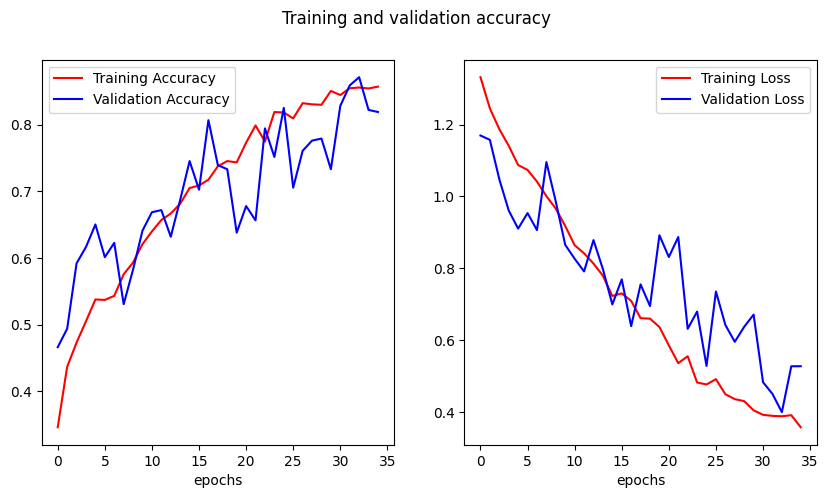

In [222]:
# Get training and validation accuracies
acc = simple_model_history.history['accuracy']
val_acc = simple_model_history.history['val_accuracy']
loss = simple_model_history.history['loss']
val_loss = simple_model_history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

## Transfer Learning

In [223]:
pre_trained_model = tf.keras.applications.resnet.ResNet50(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = "imagenet")

In [224]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_27[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [225]:
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [226]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('conv2_block2_out')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 38, 38, 256)


In [227]:
# Adding dense layers
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# Add a final layer for classification
x = tf.keras.layers.Dense(4, activation='softmax')(x)

# Append the dense network to the base model
model = tf.keras.Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_27[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [228]:
# Attach the data augmentation model to the base model
inputs = tf.keras.Input(shape=(150, 150, 3))
x = augmentation_layers(inputs)
x = model(x)

model_with_aug = tf.keras.Model(inputs, x)

In [229]:
# Set the training parameters
model_with_aug.compile( 
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"] 
    )

In [230]:
# Train the model.
transfer_history = model_with_aug.fit(
    training_dataset_final,
	epochs=20,
	validation_data=validation_dataset_final,
    class_weight=class_weights
)

Epoch 1/20
23/23 [==============================] - 57s 2s/step - loss: 513.7949 - accuracy: 0.2845 - val_loss: 106.5442 - val_accuracy: 0.3067
Epoch 2/20
23/23 [==============================] - 52s 2s/step - loss: 58.5929 - accuracy: 0.3969 - val_loss: 14.6960 - val_accuracy: 0.5429
Epoch 3/20
23/23 [==============================] - 52s 2s/step - loss: 4.6553 - accuracy: 0.4163 - val_loss: 1.2736 - val_accuracy: 0.4448
Epoch 4/20
23/23 [==============================] - 52s 2s/step - loss: 1.8775 - accuracy: 0.4010 - val_loss: 1.2308 - val_accuracy: 0.3712
Epoch 5/20
23/23 [==============================] - 52s 2s/step - loss: 1.3290 - accuracy: 0.4040 - val_loss: 1.3044 - val_accuracy: 0.4755
Epoch 6/20
23/23 [==============================] - 52s 2s/step - loss: 1.3152 - accuracy: 0.3955 - val_loss: 1.2177 - val_accuracy: 0.3681
Epoch 7/20
23/23 [==============================] - 52s 2s/step - loss: 1.2737 - accuracy: 0.3952 - val_loss: 1.2797 - val_accuracy: 0.3804
Epoch 8/20
23/

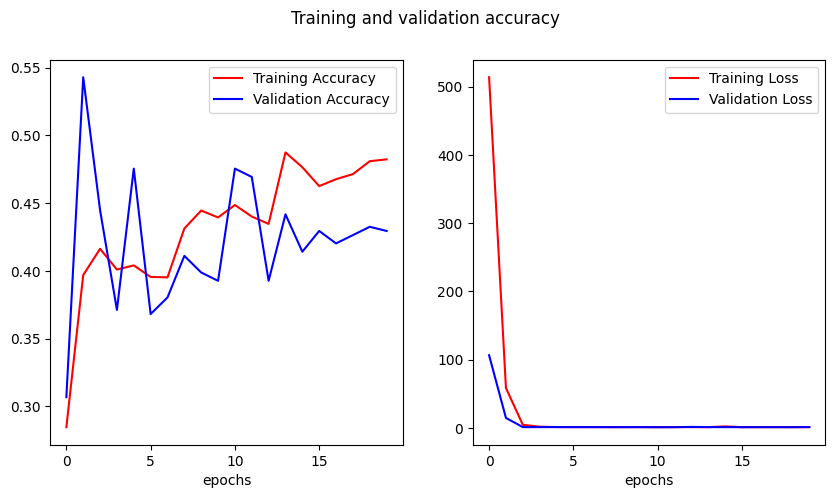

In [231]:
# Get training and validation accuracies
acc = transfer_history.history['accuracy']
val_acc = transfer_history.history['val_accuracy']
loss = transfer_history.history['loss']
val_loss = transfer_history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()